In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Remove '@' mentions, '#' hashtags and emojis
import re

def clean_text(text):
    text = text.lower()

    text = [word for word in text.split() if not (word.startswith('@') or word.startswith('#'))]
    text = " ".join(text)

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(' +', ' ', text).strip()

    return text

In [3]:
# Print text in blue on terminal
def print_blue(text):
    print(f"\033[34m{text}\033[0m")

In [4]:
import random

possible_mentions = [
            "WaterProblem",
            "RoadProblem",
            "CleanlinessProblem",
            "Police",
            "BridgeProblem",
            "TrafficPolice",
            "PostOffice",
            "BusProblem",
            "Railway",
        ]

def load_twitter_data(data_file):
    global possible_mentions
    df = pd.read_csv(data_file, encoding='cp1252')
    df = df.drop_duplicates()
    print_blue("Number of entries in the dataframe:")
    print(df.count())
    print()
    tweet = [clean_text(x) for x in df['tweet'].tolist()]
    mention = [possible_mentions.index(mention.replace('\n', '' ).replace('@', '').replace(' ', '')) for mention in df['mention'].tolist()]
    return tweet, mention

tweet, mention = load_twitter_data('train.csv')

print_blue("Sample tweets:")
for i in range(5):
  n = random.randint(0, len(tweet))
  print(tweet[n])
  print(mention[n])

Number of entries in the dataframe:
Unnamed: 0    3876
tweet         3876
mention       3876
dtype: int64

Sample tweets:
street lights are not working at ghatkopar west near r city mall, making the area very dark and unsafe at night.
3
faded signs on bridges are hard to read. replace them!
4
pedestrians have no space to walk on 14th road, khar west due to overflowing garbage bins. this issue needs immediate attention!
2
enhance passenger information systems in mira road by installing digital route maps and real-time arrival displays at bus stops. this will provide commuters with up-to-date information to plan their journeys effectively.
7
there's uncollected waste in malad west. can you increase the frequency of collection?
2


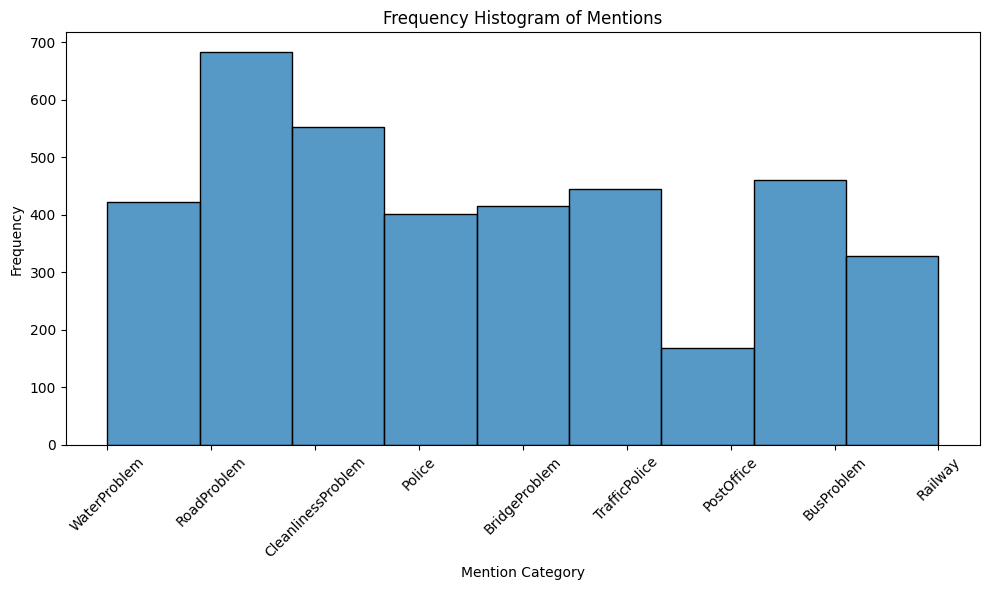

In [5]:
mention_df = pd.DataFrame(mention, columns=['mention'])

plt.figure(figsize=(10, 6))
sns.histplot(data=mention_df, x='mention', bins=len(possible_mentions), kde=False)

plt.xticks(ticks=range(len(possible_mentions)), labels=possible_mentions, rotation=45)
plt.xlabel('Mention Category')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Mentions')

plt.tight_layout()
plt.show()

In [6]:
# Count the number of classes and their counts

mention_values = mention
mention_counts = pd.Series(mention_values).value_counts()

table_data = []
for i, mention_values in enumerate(possible_mentions):
    counts = mention_counts.get(i, 0)
    table_data.append([mention_values, counts])

print(tabulate(table_data, headers=["Category", "Count"], tablefmt="grid"))

+--------------------+---------+
| Category           |   Count |
+====================+=========+
| WaterProblem       |     422 |
+--------------------+---------+
| RoadProblem        |     683 |
+--------------------+---------+
| CleanlinessProblem |     552 |
+--------------------+---------+
| Police             |     401 |
+--------------------+---------+
| BridgeProblem      |     416 |
+--------------------+---------+
| TrafficPolice      |     444 |
+--------------------+---------+
| PostOffice         |     169 |
+--------------------+---------+
| BusProblem         |     460 |
+--------------------+---------+
| Railway            |     329 |
+--------------------+---------+


### BERT Dataset Class

In [7]:
class TextClassificationDataset(Dataset):
    def __init__(self, tweet, mention, tokenizer, max_length):
        self.tweet = tweet
        self.mention = mention
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, idx):
        tweet = self.tweet[idx]
        mention = self.mention[idx]

        encoding = self.tokenizer(tweet, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)

        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(mention)}

### Custom BERT Classifier

In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, hidden_size1=64, hidden_size2=128, hidden_size3=256):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)

        self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size1)
        # self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc = nn.Linear(hidden_size1, num_classes)

        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        x = self.dropout(pooled_output)
        x = self.linear1(x)
        x = self.relu(x)

        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)

        # x = self.dropout(x)
        # x = self.linear3(x)
        # x = self.relu(x)


        # x = self.dropout(x)
        logits = self.fc(x)

        probs = self.softmax(logits)
        return probs

In [9]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [10]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

def display_confusion_matrix(actual, predicted):
  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(set(actual)))

  cm_display.plot()
  plt.show()

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    display_confusion_matrix(actual_labels, predictions)

    # Save actual and predicted labels to an Excel file
    results_df = pd.DataFrame({
        'TRUE label': [possible_mentions[label] for label in actual_labels],
        'Predicted label': [possible_mentions[pred] for pred in predictions]
    })
    results_df.to_excel('test_results.xlsx', index=False)

    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [12]:
def predict_sentiment(tweet, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(tweet, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds.item()

In [13]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = len(possible_mentions)
max_length = 128
batch_size = 16
num_epochs = 10
learning_rate = 2e-5

In [14]:
def more_clean_text(text):
    text = text.replace('\n', ' ')  # Remove all newline characters
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.replace('#', '')
    text = text.replace('@', '')
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Remove leading and trailing spaces

test = pd.read_csv("test.csv", encoding='cp1252')

test = test.dropna()

test_tweets = test.iloc[:,0].values

test_tweets = [clean_text(x) for x in test['tweet'].values.tolist()]

test_tweets = [more_clean_text(x) for x in test_tweets]

train_texts = tweet
train_labels = mention
val_texts = test_tweets
val_labels = [possible_mentions.index(value) for value in test.iloc[:,1].values]

print_blue(f"Train dataset size {len(train_texts)}")
print_blue(f"Test dataset size {len(val_texts)}")

Train dataset size 3876
Test dataset size 423


In [15]:
# Count the number of classes and their counts

mention_values = val_labels
mention_counts = pd.Series(mention_values).value_counts()

table_data = []
for i, mention_values in enumerate(possible_mentions):
    counts = mention_counts.get(i, 0)
    table_data.append([mention_values, counts])

print(tabulate(table_data, headers=["Category", "Count"], tablefmt="grid"))

+--------------------+---------+
| Category           |   Count |
+====================+=========+
| WaterProblem       |      58 |
+--------------------+---------+
| RoadProblem        |      54 |
+--------------------+---------+
| CleanlinessProblem |      63 |
+--------------------+---------+
| Police             |      82 |
+--------------------+---------+
| BridgeProblem      |      36 |
+--------------------+---------+
| TrafficPolice      |      79 |
+--------------------+---------+
| PostOffice         |      16 |
+--------------------+---------+
| BusProblem         |      17 |
+--------------------+---------+
| Railway            |      18 |
+--------------------+---------+


In [16]:
print_blue("Sample tweet:")
print(train_texts[0])
print(train_labels[0])

print()

print_blue("Sample tweet:")
print(val_texts[0])
print(val_labels[0])

Sample tweet:
it's been 24 hours with no water supply in malad west! this is unacceptable! need tankers asap!
0

Sample tweet:
it's been a week, and the garbage in front of our building in tilak nagar isn't picked up. the stench is unbearable.
2


In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [19]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
        print(f"----Epoch {epoch + 1}/{num_epochs}----")
        train(model, train_dataloader, optimizer, scheduler, device)
        print("------------ Validation/Test Set ---------------")
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Testing Accuracy: {accuracy:.4f}")
        print(report)
        print("------------ Training Set ---------------")
        accuracy, report = evaluate(model, train_dataloader, device)
        print(f"Training Accuracy: {accuracy:.4f}")
        print(report)

### **Prediction@k**

In [ ]:
import torch

correct_at_1 = 0
correct_at_2 = 0
correct_at_3 = 0
total_samples = 0

for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(outputs, dim=1)

    top_probs, top_indices = torch.topk(probabilities, 3, dim=1)

    # Calculate correct predictions at k=1, k=2, k=3
    correct_at_1 += torch.sum(top_indices[:, 0] == labels).item()
    correct_at_2 += torch.sum((top_indices[:, :2] == labels.unsqueeze(1)).any(dim=1)).item()
    correct_at_3 += torch.sum((top_indices[:, :3] == labels.unsqueeze(1)).any(dim=1)).item()

    total_samples += labels.size(0)

# Calculate precision@k
precision_at_1 = correct_at_1 / total_samples
precision_at_2 = correct_at_2 / total_samples
precision_at_3 = correct_at_3 / total_samples

print(f'Precision@1 (Accuracy): {precision_at_1:.4f}')
print(f'Precision@2: {precision_at_2:.4f}')
print(f'Precision@3: {precision_at_3:.4f}')

##**Saving the BERT model**

In [ ]:
def save_model(model, tokenizer, path):
    torch.save(model.state_dict(), f"{path}/model.pth")
    tokenizer.save_pretrained(path)

save_model(model, tokenizer, 'saved_model')

In [26]:
# Test prediction
test_text = "The train is delayed"

sentiment = predict_sentiment(test_text, model, tokenizer, device)

print(test_text)
print(f"Predicted: {possible_mentions[sentiment]}")

The train is delayed
Predicted: Railway


In [27]:
def predict_sentiments(tweets, model, tokenizer, device, max_length=128):
    model.eval()
    predictions = []

    for tweet in tweets:
        encoding = tokenizer(tweet, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.append(preds.item())

    return predictions

In [28]:
test_tweets = [
    "the road condition is worse in powai",
    "there is a pothole near a panipuri stall please repair it, casuing a inconvinience for people",
    "Wrong parking outside the building",
    "the garbage is oveflowing",
    "The parking lot in malad is not clean",
    ''' The door of Vande Bharat Train from Ahmedabad to Mumbai was jammed for an hour at Surat stn due to a tech issue

        What if there is a fire aboard the train? Or any accident occurs?

        This is a serious safety hazard that cannot be overlooked.
        Risk is too high to let the trains run ''',
    "Thane Grand Central Park but to see that people are bringing their vehicles in Narrow and unplanned regions of Kolshet and Balkum and creating Thane Grand Central",
    "Triple parking arrangement on Press Enclave road... If there is no place to park a car, anyone can come here and park their car. If there is no space, you can also do triple parking. Even if there is no room for vehicles on the roads, it will work. The traffic police does not take any action.",
    "I am seriously thinking of moving out from Mumbai due to the pathetic conditions on the road.",
    "I am seriously thinking of moving out from Mumbai due to the pathetic jams on the road.",
    "I am happy because the road was not with garbage",
    "I am not happy because the road was with garbage"
    ]

# Get the predictions
predictions = predict_sentiments(test_tweets, model, tokenizer, device)

for tweet, sentiment in zip(test_tweets, predictions):
    print_blue(tweet)
    print(f"Predicted: {possible_mentions[sentiment]}")
    print()


the road condition is worse in powai
Predicted: RoadProblem

there is a pothole near a panipuri stall please repair it, casuing a inconvinience for people
Predicted: RoadProblem

Wrong parking outside the building
Predicted: Railway

the garbage is oveflowing
Predicted: CleanlinessProblem

The parking lot in malad is not clean
Predicted: CleanlinessProblem

 The door of Vande Bharat Train from Ahmedabad to Mumbai was jammed for an hour at Surat stn due to a tech issue

        What if there is a fire aboard the train? Or any accident occurs?

        This is a serious safety hazard that cannot be overlooked.
        Risk is too high to let the trains run 
Predicted: Railway

Thane Grand Central Park but to see that people are bringing their vehicles in Narrow and unplanned regions of Kolshet and Balkum and creating Thane Grand Central
Predicted: TrafficPolice

Triple parking arrangement on Press Enclave road... If there is no place to park a car, anyone can come here and park their car

In [29]:
generated_tweets = [
"Facing severe water shortage in our area for the past week. Can this issue be addressed urgently?",
"Massive potholes on the main road causing traffic jams and accidents. When will this be fixed?",
"Garbage has been piling up in our neighborhood for days. Please send a cleaning crew ASAP.",
"There's been a rise in thefts in our locality. Can patrolling be increased in the area?",
"The footbridge near the station is in dire need of repairs. It's a safety hazard for commuters.",
"Illegal parking is blocking the main street, causing inconvenience to everyone. Can action be taken?",
"Still waiting for my package to be delivered. It's been over a week. Can someone look into this?",
"buses have been running late recently, making it hard to reach work on time. Please improve the service.",
"Trains are constantly delayed during peak hours. This is causing a lot of inconvenience to daily commuters. Please fix this."
]

# Get the predictions
predictions = predict_sentiments(generated_tweets, model, tokenizer, device)

# Print the results
for tweet, sentiment in zip(generated_tweets, predictions):
    print_blue(tweet)
    print(f"Predicted: {possible_mentions[sentiment]}")
    print()


Facing severe water shortage in our area for the past week. Can this issue be addressed urgently?
Predicted: WaterProblem

Massive potholes on the main road causing traffic jams and accidents. When will this be fixed?
Predicted: RoadProblem

Garbage has been piling up in our neighborhood for days. Please send a cleaning crew ASAP.
Predicted: CleanlinessProblem

There's been a rise in thefts in our locality. Can patrolling be increased in the area?
Predicted: Police

The footbridge near the station is in dire need of repairs. It's a safety hazard for commuters.
Predicted: Railway

Illegal parking is blocking the main street, causing inconvenience to everyone. Can action be taken?
Predicted: RoadProblem

Still waiting for my package to be delivered. It's been over a week. Can someone look into this?
Predicted: PostOffice

buses have been running late recently, making it hard to reach work on time. Please improve the service.
Predicted: BusProblem

Trains are constantly delayed during pea

## **Location Information Extraction**

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

In [ ]:
from transformers import pipeline

ner_pipeline = pipeline("ner", grouped_entities=True)

In [32]:
def extract_location_from_ner(tweet):
    entities = ner_pipeline(tweet)
    locations = [entity['word'] for entity in entities if entity['entity_group'] == 'LOC']
    if locations:
        return locations
    else:
        return []

### **Code to extract city out of extract_location_from_ner and Coordinates**

In [33]:
import math

def get_nearest_location_index(lat, lon, ambiguous_locations):
    """
    Finds the index of the nearest location from ambiguous_locations
    based on the user's current latitude and longitude.

    Parameters:
    - lat (float): User's current latitude.
    - lon (float): User's current longitude.
    - ambiguous_locations (dict): Dictionary where keys are indices
      and values are dictionaries containing 'lat' and 'lon' keys for each location.

    Returns:
    - int: Index of the nearest location.
    """

    def haversine_distance(lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        r = 6371  # Radius of Earth in kilometers. Use 3956 for miles.
        return c * r

    nearest_index = None
    min_distance = float('inf')

    for index, location_info in ambiguous_locations.items():
        location_lat = location_info['lat']
        location_lon = location_info['lon']
        distance = haversine_distance(lat, lon, location_lat, location_lon)
        if distance < min_distance:
            min_distance = distance
            nearest_index = index

    return nearest_index

In [34]:
import requests

def coordinates_details(lat, lon):
      key = "{GOOGLE_API_KEY_HERE}"
      url = "https://maps.googleapis.com/maps/api/geocode/json?latlng="+str(lat)+","+str(lon)+"&key="+key
      headers = {"Content-Type": "application/json"}

      response = requests.get(url, headers=headers)
      response = response.json()

      area = ""
      for location in response["results"][0]["address_components"]:
        if "locality" in location["types"]:
          area = area[:-2]
          break
        area += location["long_name"]+", "

      payload = {
          "address_components": response["results"][0]["address_components"],
          "formatted_address": response["results"][0]["formatted_address"],
          "location_coordinates": response["results"][0]["geometry"]["location"],
          "area": area,
          "city": [location["long_name"] for location in response["results"][0]["address_components"] if "locality" in location["types"]][0],
          "country": [location["long_name"] for location in response["results"][0]["address_components"] if "country" in location["types"]][0],

      }
      return payload

def area_details(location, lat, lon):
      key = "{GOOGLE_API_KEY_HERE}"

      city = coordinates_details(lat, lon)["city"]

      location = location.replace(' ','+') + "+" + city

      url = "https://maps.googleapis.com/maps/api/geocode/json?address="+location+"&key="+key
      headers = {"Content-Type": "application/json"}

      response = requests.get(url, headers=headers)
      response = response.json()

      # if multiple location with same name we need nearest location to be fetched
      nearest_index = 0
      if len(response["results"]) > 1:
        ambigous_location = [result["geometry"]["location"] for result in response["results"]] # getting list of locations coordinates for each address
        ambigous_location = dict(enumerate(ambigous_location))
        nearest_index = get_nearest_location_index(lat, lon, ambigous_location)

      area = ""
      for location in response["results"][nearest_index]["address_components"]:
        if "locality" in location["types"]:
          area = area[:-2]
          break
        area += location["long_name"]+", "

      payload = {
          "address_components": response["results"][nearest_index]["address_components"],
          "formatted_address": response["results"][nearest_index]["formatted_address"],
          "location_coordinates": response["results"][nearest_index]["geometry"]["location"],
          "area": area,
          "city": [location["long_name"] for location in response["results"][nearest_index]["address_components"] if "locality" in location["types"]][0],
          "country": [location["long_name"] for location in response["results"][nearest_index]["address_components"] if "country" in location["types"]][0],
      }
      return payload

def get_location_details(tweet, lat, lon):
    locations = extract_location_from_ner(tweet)
    if len(locations) == 0:
      return coordinates_details(lat,lon)
    else:
      return area_details(locations[0], lat, lon)